This notebooks is used to  investigating how FHD and py21cmwedge grid baselines.

We will compare a single baseline array and a double baseline array using the HFSS beam of a HERA dish.

In [1]:
%matplotlib notebook
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
from astropy.io import fits
from matplotlib.colors import SymLogNorm, LogNorm
from py21cmwedge import UVGridder, cosmo, dft
from scipy.io import readsav
import glob
# filename='/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'
filename='/home/mkolopanis/fhd_wedge_power/FHD_beam_x.fits'

 Setting up the Beam, FHD output and py21cmwedge objects
 
 A map rotation may be necessary if the beams have different zenith pointings, or if the packages treat polarization differently.

In [2]:
def rotate_map(hmap, rot=None, deg=False, **kwargs):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=deg, rot=rot, **kwargs)

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [3]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, 'BEAM_X')
freqs = fits.getdata(filename, 'FREQS_X')
ind = np.argmin(abs(freqs-150e6))
beam_150 = beam[:,ind]
freq = 150e6
redshift = 1420e6/freq - 1

In [4]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
weight_list = glob.glob('/home/mkolopanis/fhd_wedge_power/fhd_hera_37_6sep/ps/*weights_uvf*.idlsave')
weight_filename = weight_list.pop()
weight_file = readsav(weight_filename)

kx = weight_file.kx_rad_vals/cosmo.comoving_distance(redshift)
ky = weight_file.ky_rad_vals/cosmo.comoving_distance(redshift)
weights_cube = weight_file.weights_cube

fhd_us = cosmo.kperp2u(kx,8.47)
fhd_ind = weights_cube.shape[0]/2

In [5]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
# For a Single Baseline
uvf_list = glob.glob('/home/mkolopanis/fhd_wedge_power/fhd_hera_37_single_baseline/8MHz_single_baseline_simvis-noiseless_even_gridded_uvf.sav')
uvf_filename = uvf_list.pop()
single_uvf_file = readsav(uvf_filename)
single_uvf_cube = single_uvf_file.weights_uv_arr[fhd_ind].item()

uvf_ind = np.shape(single_uvf_cube)[0]/2

In [6]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
# For Two Baselines
uvf_list = glob.glob('/home/mkolopanis/fhd_wedge_power/fhd_hera_37_double_baseline/8MHz_double_baseline_simvis-noiseless_even_gridded_uvf.sav')
uvf_filename = uvf_list.pop()
double_uvf_file = readsav(uvf_filename)
double_uvf_cube = double_uvf_file.weights_uv_arr[fhd_ind].item()

uvf_ind = np.shape(double_uvf_cube)[0]/2

In [7]:
# delta_u = np.diff(fhd_us)[0]
delta_u = .5

FHD is simulating a 660s observation. It relies on a beam_offset_time=330s. 
I believe this is to set the zenith pointing for the beam.

FHD and py21cmwedge appear to have a polarization difference too.

We Rotate the beam by 90 degress around the Z axis, then rotate by a 660s drift along the Y axis.

This 660s is the exact legnth of time for the observation loaded from the above FHD and eppsilon outputs.
While the beams_offset_time=330s in FHD, we find it necessary to rotate by the full observation time.

In [8]:
new_beam= rotate_map(beam_150, [np.pi/2,0,0], deg=False)
new_beam= rotate_map(new_beam, [0,np.pi/(12*3600) *330 * 2,0], deg=False)
uv_beam = dft.hpx_to_uv(new_beam*new_beam.conj(), delta_u)
uv_beam /= uv_beam.sum() 
inds = np.argwhere(np.abs(uv_beam) <= np.abs(uv_beam).max()/10)
uv_beam[inds[:,0], inds[:,1]] = 0

This is in the starting UVGridder object.

I will start with the HERA 37 antenna positions and then create
arrays with only 1 or 2 baselines from the uvw_array created by this object.


We will also keep the longest baseline in the array to help preseve the size of the uvf cube in each object.
This long baseline is far from the baselines in question and should not affect the analysis.

In [9]:
# Set up the UVGridder object for HERA 37
gridder = UVGridder()
gridder.set_uv_delta(delta_u) # Size of pixel in the UV plane (in wavelengths)
gridder.wavelength_scale = 2 # gridder.set_beam(beam_150)
gridder.set_uv_beam(uv_beam)
gridder.read_antpos('/home/mkolopanis/hera_sims/hera_layouts/antenna_positions_37.dat', skiprows=1)
gridder.set_freqs(freq)
gridder.calc_all()
us_grid = np.arange(gridder.uv_size).astype(np.float64) - (gridder.uv_size -1)/2
us_grid *= gridder.uv_delta
ks_grid = cosmo.u2kperp(us_grid, redshift)

In [10]:
new_dict = {}
for key in gridder.uvbins:
    new_dict[key] = [gridder.uvbins[key][0]]
#     if abs(float(key.split(',')[0])) > 290:
#         print key, gridder.uvbins[key][0]    
#         print new_dict[key]    
new_uvw_array = []

for key in new_dict:
    _u,_v = map(float, key.split(','))
    new_uvw_array.append([_u,_v,0])

new_uvw_array= np.unique(new_uvw_array,axis=0)
uvw_ind_min = np.argmin(np.linalg.norm(new_uvw_array,axis=1))
uvw_ind_max = np.argmax(np.linalg.norm(new_uvw_array,axis=1))

In [11]:
import copy
single_gridder = copy.copy(gridder)
single_gridder.set_uvw_array(new_uvw_array)
single_gridder.set_uvw_array([new_uvw_array[uvw_ind_max],
#                               [14.35,0,0],[2*15,0,0]])
                              -new_uvw_array[uvw_ind_min], new_uvw_array[uvw_ind_min]])
single_gridder.calc_all()
single_gridder.uvf_cube[0] *= np.abs(single_uvf_cube).max()/np.abs(single_gridder.uvf_cube[0]).max()

In [12]:
double_gridder = copy.copy(gridder)
double_gridder.set_uvw_array(new_uvw_array)
double_gridder.set_uvw_array([new_uvw_array[uvw_ind_max],
#                               [14.35,0,0],[2*15,0,0]])
                              new_uvw_array[uvw_ind_min], -new_uvw_array[uvw_ind_min],
                              new_uvw_array[uvw_ind_min]*2, -new_uvw_array[uvw_ind_min]*2])
double_gridder.calc_all()
double_gridder.uvf_cube[0] *= np.abs(single_uvf_cube).max()/np.abs(double_gridder.uvf_cube[0]).max()

In [13]:
uvf_size = np.size(single_uvf_cube[uvf_ind])
uvf_us = np.arange(-uvf_size/2,uvf_size/2)*.5
uvf_us_ind = np.logical_and(uvf_us > 10, uvf_us < 45)
fhd_us_ind = np.logical_and(fhd_us > 10, fhd_us < 45)
ks_ind = np.logical_and(us_grid > 10, us_grid < 45)

# Single Baseline Array

<IPython.core.display.Javascript object>


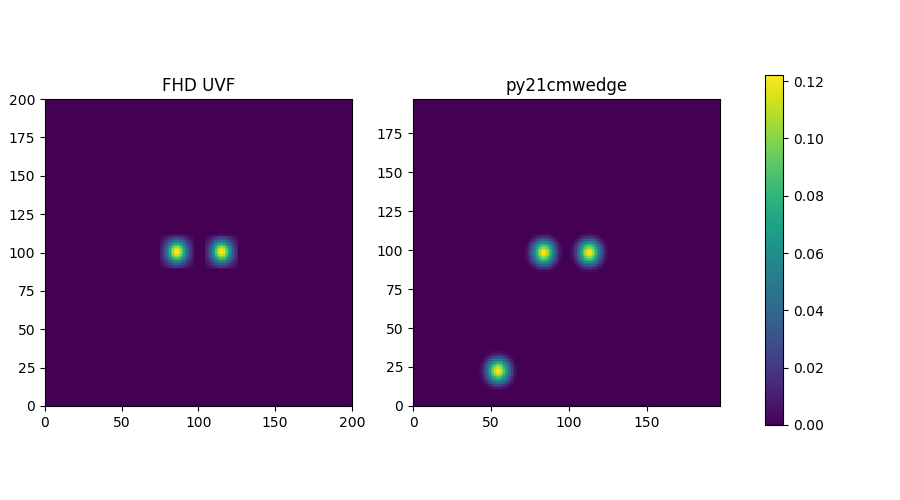

In [14]:
fig, ax = subplots(1,2, figsize=(9,5))
subplots_adjust(left=.05, right=.8)
im = ax[0].pcolorfast(np.abs(single_uvf_cube)[650:850, 650:850])
ax[0].set_aspect('equal')
ax[0].set_title('FHD UVF')
# fig.colorbar(im, ax=ax[0])

im1 = ax[1].pcolorfast(np.abs(single_gridder.uvf_cube[0]))
ax[1].set_aspect('equal')
ax[1].set_title('py21cmwedge')

cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1,cax=cax)#,ax=ax[1])

Using the single_uvf_cube from FHD we can compare against the py21cmwedge output with 1 baseline


<IPython.core.display.Javascript object>


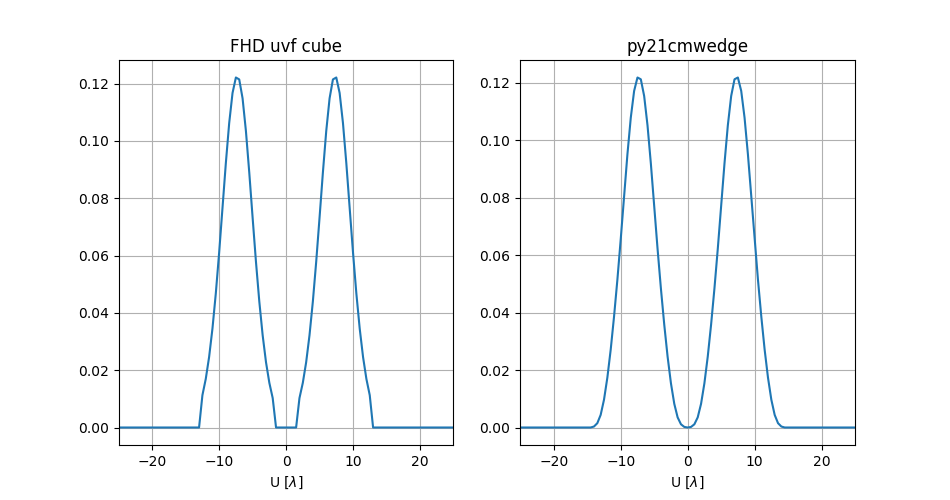

In [15]:
print "Using the single_uvf_cube from FHD we can compare against the py21cmwedge output with 1 baseline"

fig, axes = subplots(ncols=2, figsize=(9.5,5),sharex=True)

axes[0].plot(uvf_us,np.abs(single_uvf_cube[ uvf_ind]))
# axes[0].plot(uvf_us[uvf_us_ind], np.abs(single_uvf_cube[uvf_ind])[uvf_us_ind], 'kd', mfc='none')

axes[0].grid()
axes[0].set_xlim([-25,25])
axes[0].set_title("FHD uvf cube")
axes[0].set_xlabel('U [$\lambda$]')

axes[1].plot(us_grid, np.abs(single_gridder.uvf_cube[0,(single_gridder.uv_size -1)/2]))
# axes[1].plot(us_grid[ks_ind], np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size-1)/2])[ks_ind],
#              'kd', mfc='none')

axes[1].grid()
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('U [$\lambda$]')

In [16]:
fhd_mean = np.mean(np.abs(single_uvf_cube[uvf_ind])[uvf_us_ind])
fhd_std = np.std(np.abs(single_uvf_cube[uvf_ind])[uvf_us_ind])
wedge_mean = np.mean(np.abs(single_gridder.uvf_cube[0,(single_gridder.uv_size -1)/2])[ks_ind])
wedge_std = np.std(np.abs(single_gridder.uvf_cube[0,(single_gridder.uv_size -1)/2])[ks_ind])


print "Simulation\tMean\t\tStd\t\tStd/Mean"
print "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(fhd_mean, fhd_std, fhd_std/fhd_mean)
print "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(wedge_mean, wedge_std, wedge_std/wedge_mean)

Simulation	Mean		Std		Std/Mean
FHD        	1.943e-03	7.742e-03	3.984e+00
Py21cmwedge	2.179e-03	8.476e-03	3.890e+00


<IPython.core.display.Javascript object>


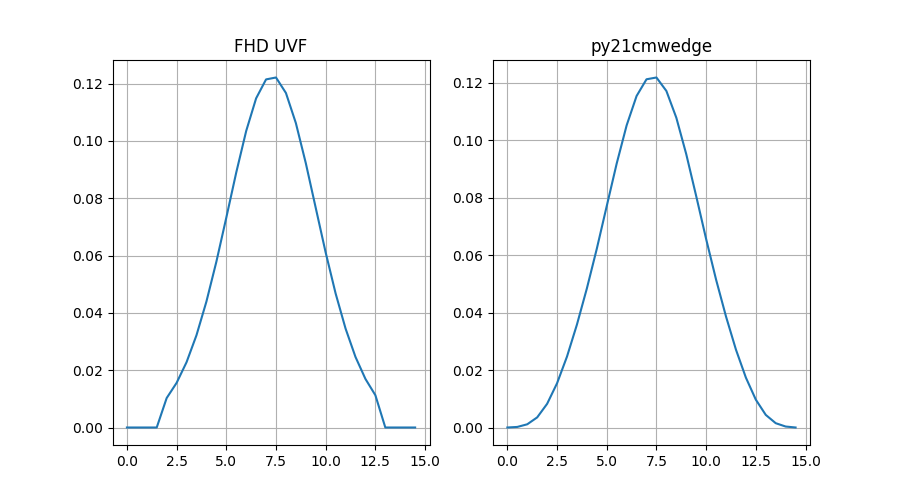

In [17]:
fig, ax = subplots(1,2, figsize=(9,5),sharex=True)

fhd_size = np.shape(single_uvf_cube)[0]
fhd_slice = [fhd_size/2, int(fhd_size/2 + 15/delta_u)]
ax[0].grid()

im = ax[0].plot(uvf_us[fhd_slice[0]:fhd_slice[1]], np.abs(single_uvf_cube)[fhd_size/2, fhd_slice[0]:fhd_slice[1]])
ax[0].set_title('FHD UVF')
# fig.colorbar(im, ax=ax[0])
slice_inds = [(single_gridder.uv_size-1)/2, int((single_gridder.uv_size-1)/2 + 15/single_gridder.uv_delta)]
im1 = ax[1].plot(us_grid[slice_inds[0]:slice_inds[1]],np.abs(single_gridder.uvf_cube[0,(single_gridder.uv_size-1)/2,
                                                                 slice_inds[0]:slice_inds[1]]))
ax[1].set_title('py21cmwedge')
ax[1].grid()

Here we compare cuts along the horizontal(v=0) and vertical(u=0) axes


<IPython.core.display.Javascript object>


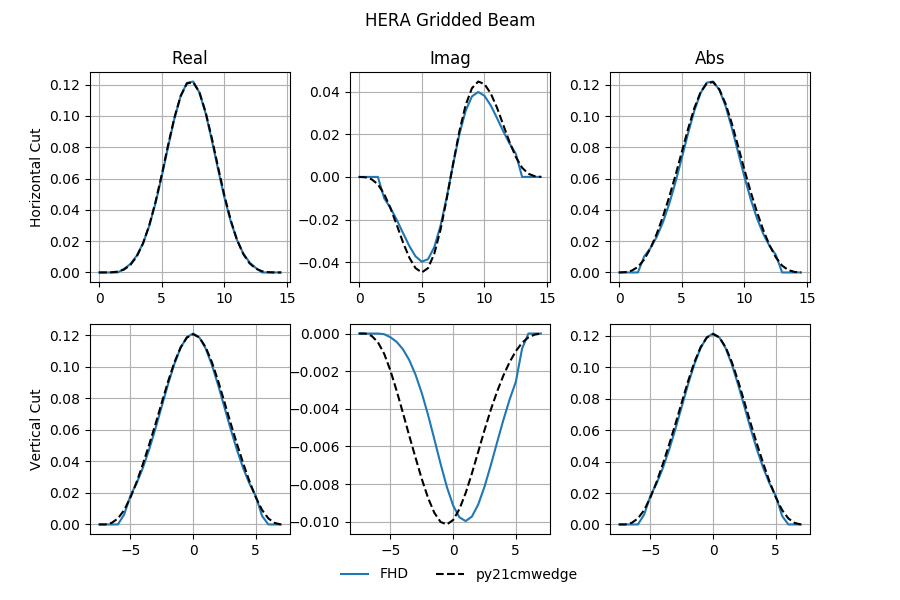

In [18]:
print "Here we compare cuts along the horizontal(v=0) and vertical(u=0) axes"
fig, ax = subplots(2,3, figsize=(9,6))

fhd_size = np.shape(single_uvf_cube)[0]
fhd_slice = [fhd_size/2, fhd_size/2, int(fhd_size/2 + 15/delta_u)]
# fhd_slice = [int(fhd_size/2 + 7.5/delta_u), int(fhd_size/2 - 7.5/delta_u), int(fhd_size/2 + 7.5/delta_u)]
for i in xrange(len(ax.ravel())):
    ax.ravel()[i].grid()

ax[0,0].set_ylabel('Horizontal Cut')
ax[1,0].set_ylabel('Vertical Cut')

ax[0,0].set_title('Real')
ax[0,1].set_title('Imag')
ax[0,2].set_title('Abs')
    
fig.subplots_adjust(left=.1, wspace=.3)
fig.suptitle('HERA Gridded Beam')
im = ax[0,0].plot(uvf_us[fhd_slice[1]:fhd_slice[2]], 
                np.real(single_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
slice_inds = [(single_gridder.uv_size-1)/2, (single_gridder.uv_size-1)/2, 
              int((single_gridder.uv_size-1)/2. + 15/single_gridder.uv_delta)]
# slice_inds = [int((single_gridder.uv_size-1)/2 + 7.5/single_gridder.uv_delta), 
#               int((single_gridder.uv_size-1)/2 - 7.5/single_gridder.uv_delta), 
#               int((single_gridder.uv_size-1)/2. + 7.5/single_gridder.uv_delta)]
ax[0,0].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.real(single_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]),
           'k--',label='py21cmwedge')

im = ax[0,1].plot(uvf_us[fhd_slice[1]:fhd_slice[2]],
                np.imag(single_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
ax[0,1].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.imag(single_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]),
           'k--', label='py21cmwedge')

ax[0,2].plot(uvf_us[fhd_slice[1]:fhd_slice[2]],
                np.abs(single_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
ax[0,2].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.abs(single_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]), 
           'k--', label='py21cmwedge')

##############

fhd_slice_y = [int(fhd_size/2 + 7.3/delta_u), int(fhd_size/2 - 7.5/delta_u), int(fhd_size/2 + 7.5/delta_u)]
slice_inds_y = [int((single_gridder.uv_size-1)/2 + 7.3/single_gridder.uv_delta), 
              int((single_gridder.uv_size-1)/2 - 7.5/single_gridder.uv_delta), 
              int((single_gridder.uv_size-1)/2. + 7.5/single_gridder.uv_delta)]

ax[1,0].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]], 
                np.real(single_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,0].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.real(single_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]),
           'k--',label='py21cmwedge')

ax[1,1].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]],
                np.imag(single_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,1].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.imag(single_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]),
           'k--', label='py21cmwedge')

ax[1,2].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]],
                np.abs(single_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,2].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.abs(single_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]), 
           'k--', label='py21cmwedge')
ax[1,1].legend(frameon=False, bbox_to_anchor=(1.2,-.1), ncol=2)

# 2 Baseline Array

<IPython.core.display.Javascript object>


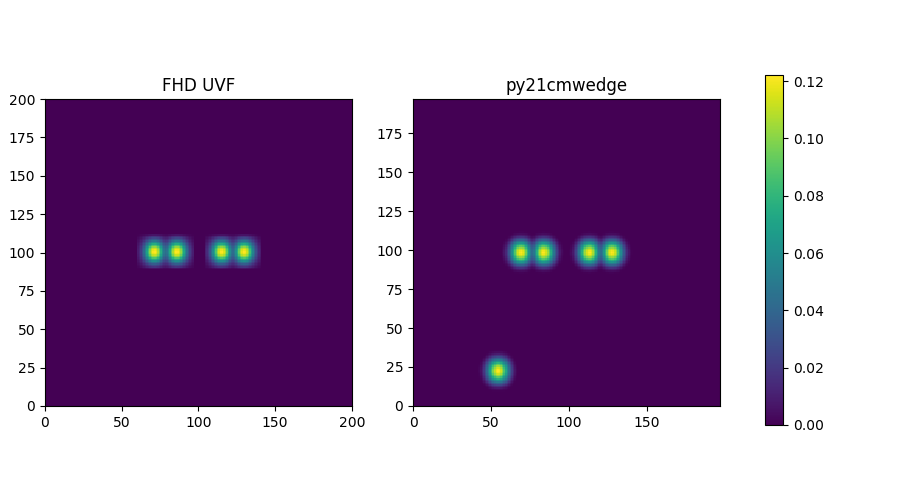

In [19]:
fig, ax = subplots(1,2, figsize=(9,5))
subplots_adjust(left=.05, right=.8)
im = ax[0].pcolorfast(np.abs(double_uvf_cube)[650:850, 650:850])
ax[0].set_aspect(1, adjustable='box')
ax[0].set_title('FHD UVF')
# fig.colorbar(im, ax=ax[0])

im1 = ax[1].pcolorfast(np.abs(double_gridder.uvf_cube[0]))
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title('py21cmwedge')

cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1,cax=cax)#,ax=ax[1])

Using the double_uvf_cube from FHD we can compare against the py21cmwedge output with 2 baselines


<IPython.core.display.Javascript object>


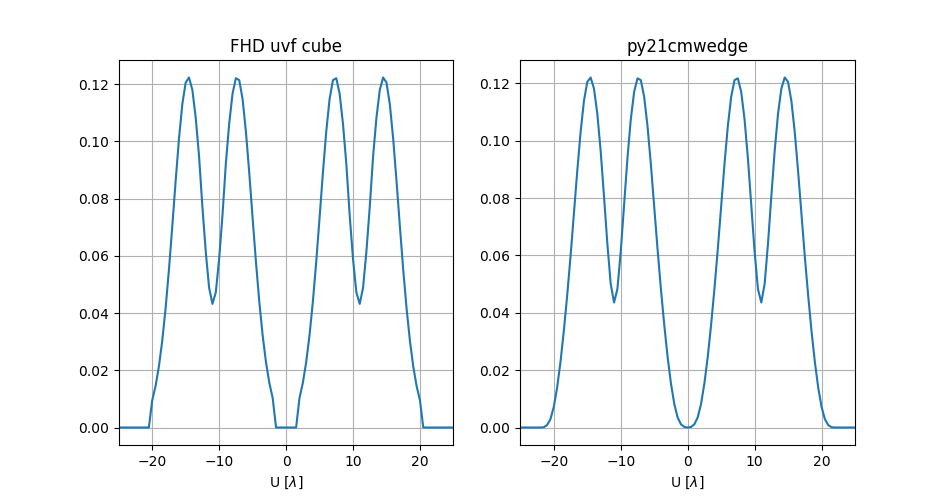

In [20]:
print "Using the double_uvf_cube from FHD we can compare against the py21cmwedge output with 2 baselines"

fig, axes = subplots(ncols=2, figsize=(9.5,5), sharex=True)

axes[0].plot(uvf_us,np.abs(double_uvf_cube[ uvf_ind]))
# axes[0].plot(uvf_us[uvf_us_ind], np.abs(double_uvf_cube[uvf_ind])[uvf_us_ind], 'kd', mfc='none')

axes[0].grid()
axes[0].set_xlim([-25,25])
axes[0].set_title("FHD uvf cube")
axes[0].set_xlabel('U [$\lambda$]')

axes[1].plot(us_grid, np.abs(double_gridder.uvf_cube[0,(double_gridder.uv_size -1)/2]))
# axes[1].plot(us_grid[ks_ind], np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size-1)/2])[ks_ind],
#              'kd', mfc='none')

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('U [$\lambda$]')

In [21]:
fhd_mean = np.mean(np.abs(double_uvf_cube[uvf_ind])[uvf_us_ind])
fhd_std = np.std(np.abs(double_uvf_cube[uvf_ind])[uvf_us_ind])
wedge_mean = np.mean(np.abs(double_gridder.uvf_cube[0,(double_gridder.uv_size -1)/2])[ks_ind])
wedge_std = np.std(np.abs(double_gridder.uvf_cube[0,(double_gridder.uv_size -1)/2])[ks_ind])


print "Simulation\tMean\t\tStd\t\tStd/Mean"
print "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(fhd_mean, fhd_std, fhd_std/fhd_mean)
print "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(wedge_mean, wedge_std, wedge_std/wedge_mean)

Simulation	Mean		Std		Std/Mean
FHD        	2.008e-02	3.699e-02	1.842e+00
Py21cmwedge	2.060e-02	3.757e-02	1.824e+00


<IPython.core.display.Javascript object>


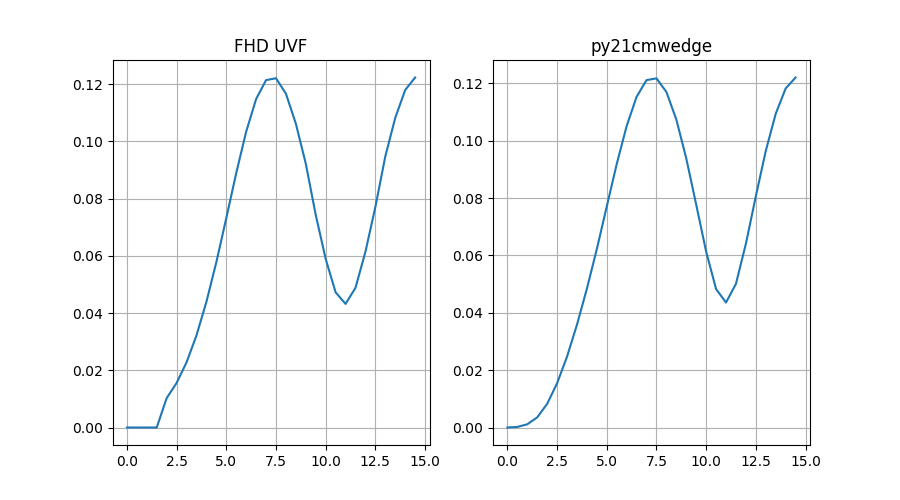

In [22]:
fig, ax = subplots(1,2, figsize=(9,5), sharex=True)

fhd_size = np.shape(double_uvf_cube)[0]
fhd_slice = [fhd_size/2, int(fhd_size/2 + 15/delta_u)]
ax[0].grid()

im = ax[0].plot(uvf_us[fhd_slice[0]:fhd_slice[1]], np.abs(double_uvf_cube)[fhd_size/2, fhd_slice[0]:fhd_slice[1]])
ax[0].set_title('FHD UVF')
# fig.colorbar(im, ax=ax[0])
slice_inds = [(double_gridder.uv_size-1)/2, int((double_gridder.uv_size-1)/2 + 15/double_gridder.uv_delta)]
im1 = ax[1].plot(us_grid[slice_inds[0]:slice_inds[1]],np.abs(double_gridder.uvf_cube[0,(double_gridder.uv_size-1)/2,
                                                                 slice_inds[0]:slice_inds[1]]))
ax[1].set_title('py21cmwedge')
ax[1].grid()

Here we compare cuts along the horizontal(v=0) and vertical(u=0) axes


<IPython.core.display.Javascript object>


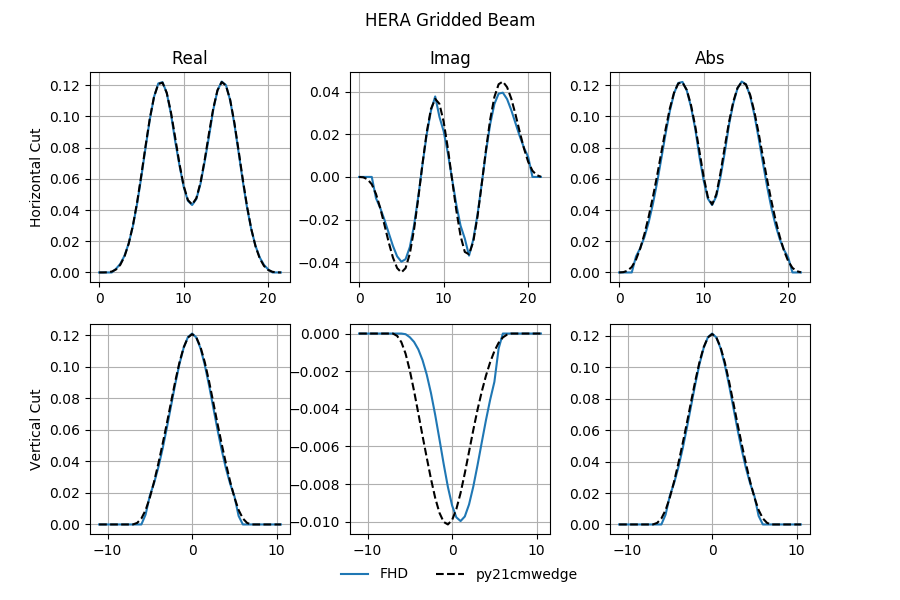

In [23]:
print "Here we compare cuts along the horizontal(v=0) and vertical(u=0) axes"
fig, ax = subplots(2,3, figsize=(9,6))

uv_extent = 22

fhd_size = np.shape(double_uvf_cube)[0]
fhd_slice = [fhd_size/2, fhd_size/2, int(fhd_size/2 + uv_extent/delta_u)]
# fhd_slice = [int(fhd_size/2 + 7.5/delta_u), int(fhd_size/2 - 7.5/delta_u), int(fhd_size/2 + 7.5/delta_u)]
for i in xrange(len(ax.ravel())):
    ax.ravel()[i].grid()

ax[0,0].set_ylabel('Horizontal Cut')
ax[1,0].set_ylabel('Vertical Cut')

ax[0,0].set_title('Real')
ax[0,1].set_title('Imag')
ax[0,2].set_title('Abs')
    
fig.subplots_adjust(left=.1, wspace=.3)
fig.suptitle('HERA Gridded Beam')
im = ax[0,0].plot(uvf_us[fhd_slice[1]:fhd_slice[2]], 
                np.real(double_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
slice_inds = [(double_gridder.uv_size-1)/2, (double_gridder.uv_size-1)/2, 
              int((double_gridder.uv_size-1)/2. + uv_extent/double_gridder.uv_delta)]
# slice_inds = [int((double_gridder.uv_size-1)/2 + 7.5/double_gridder.uv_delta), 
#               int((double_gridder.uv_size-1)/2 - 7.5/double_gridder.uv_delta), 
#               int((double_gridder.uv_size-1)/2. + 7.5/double_gridder.uv_delta)]
ax[0,0].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.real(double_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]),
           'k--',label='py21cmwedge')

im = ax[0,1].plot(uvf_us[fhd_slice[1]:fhd_slice[2]],
                np.imag(double_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
ax[0,1].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.imag(double_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]),
           'k--', label='py21cmwedge')

ax[0,2].plot(uvf_us[fhd_slice[1]:fhd_slice[2]],
                np.abs(double_uvf_cube)[fhd_slice[0], fhd_slice[1]:fhd_slice[2]],
                label='FHD')
ax[0,2].plot(us_grid[slice_inds[1]:slice_inds[2]],
           np.abs(double_gridder.uvf_cube[0,slice_inds[0],slice_inds[1]:slice_inds[2]]), 
           'k--', label='py21cmwedge')

##############

fhd_slice_y = [int(fhd_size/2 + 7.3/delta_u), int(fhd_size/2 - uv_extent/2/delta_u), 
               int(fhd_size/2 + uv_extent/2./delta_u)]
slice_inds_y = [int((double_gridder.uv_size-1)/2 + 7.3/double_gridder.uv_delta), 
              int((double_gridder.uv_size-1)/2 - uv_extent/2/double_gridder.uv_delta), 
              int((double_gridder.uv_size-1)/2. + uv_extent/2/double_gridder.uv_delta)]

ax[1,0].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]], 
                np.real(double_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,0].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.real(double_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]),
           'k--',label='py21cmwedge')

ax[1,1].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]],
                np.imag(double_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,1].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.imag(double_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]),
           'k--', label='py21cmwedge')

ax[1,2].plot(uvf_us[fhd_slice_y[1]:fhd_slice_y[2]],
                np.abs(double_uvf_cube.T)[fhd_slice_y[0], fhd_slice_y[1]:fhd_slice_y[2]],
                label='FHD')
ax[1,2].plot(us_grid[slice_inds_y[1]:slice_inds_y[2]],
           np.abs(double_gridder.uvf_cube[0].T[slice_inds_y[0],slice_inds_y[1]:slice_inds_y[2]]), 
           'k--', label='py21cmwedge')
ax[1,1].legend(frameon=False, bbox_to_anchor=(1.2,-.1), ncol=2)

The same UVF cubes in the absolute along with residuals


<IPython.core.display.Javascript object>


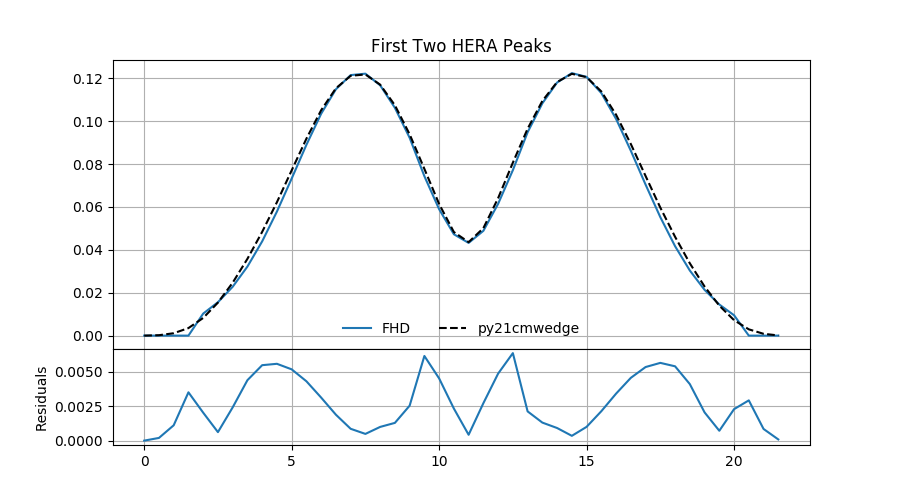

In [24]:
print 'The same UVF cubes in the absolute along with residuals'
fig, ax = subplots(2,1, figsize=(9,5), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

fhd_size = np.shape(double_uvf_cube)[0]
fhd_slice = [fhd_size/2, int(fhd_size/2 + 22/delta_u)]
ax[0].grid()
ax[1].grid()
fig.subplots_adjust(hspace=0)
im = ax[0].plot(uvf_us[fhd_slice[0]:fhd_slice[1]], np.abs(double_uvf_cube)[fhd_size/2, fhd_slice[0]:fhd_slice[1]],
            label='FHD')
ax[0].set_title('First Two HERA Peaks')
# fig.colorbar(im, ax=ax[0])
slice_inds = [(double_gridder.uv_size-1)/2, 
              int((double_gridder.uv_size-1)/2. + 22/double_gridder.uv_delta)]
ax[0].plot(us_grid[slice_inds[0]:slice_inds[1]],np.abs(double_gridder.uvf_cube[0,(double_gridder.uv_size-1)/2,
                                                                 slice_inds[0]:slice_inds[1]] ), 'k--',
       label='py21cmwedge')
ax[0].legend(loc='lower center',frameon=False, ncol=2)

ax[1].set_ylabel('Residuals')
ax[1].plot(us_grid[slice_inds[0]:slice_inds[1]], np.abs(
           double_gridder.uvf_cube[0,(double_gridder.uv_size-1)/2, slice_inds[0]:slice_inds[1]] - 
           double_uvf_cube[fhd_size/2, fhd_slice[0]:fhd_slice[1]]) 
           )

In [37]:
print 'Let us check on the values we would expect from adding 2 baselines for each program'
u_11_21 = np.argmin(abs(us_grid-11))
bl1_21= single_gridder.uvf_cube[0,(single_gridder.uv_size-1)/2, u_11_21]
bl1_2_21 = 2*single_gridder.uvf_cube[0,(single_gridder.uv_size-1)/2, u_11_21]
bl2_21 = double_gridder.uvf_cube[0,(double_gridder.uv_size-1)/2, u_11_21]

u_11_uvf = np.argmin(abs(uvf_us-11))
bl1_fhd= single_uvf_cube[uvf_ind, u_11_uvf]
bl1_2_fhd = 2*single_uvf_cube[uvf_ind, u_11_uvf]
bl2_fhd = double_uvf_cube[uvf_ind, u_11_uvf]

print('Program \t Single \t\t\t 2*Single \t\t\t Double')
print('Py21cmwedge \t {0:>13.9f} \t {1:.9f} \t {2:.9f}'.format(bl1_21, bl1_2_21, bl2_21))
print('FHD \t\t {0:.9f} \t {1:.9f} \t {2:.9f}'.format(bl1_fhd, bl1_2_fhd, bl2_fhd))

Let us check on the values we would expect from adding 2 baselines for each program
Program 	 Single 			 2*Single 			 Double
Py21cmwedge 	 0.020829731+0.032494278j 	 0.041659462+0.064988556j 	 0.043564684-0.001306550j
FHD 		 0.020689327+0.027627287j 	 0.041378655+0.055254575j 	 0.043203976-0.001080456j
